In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns

from scripts.helper import toBin, toDec, padList

# Integer Division:

$f(a, b) = [\text{quotient}(a,b) ,  \text{remainder}(a,b)], \space a,b \in \mathbb{N}_{[1,2000]}$

## Data Generation

In [2]:
lb = 1
ub_a = 2000
ub_b = 2000

n_digits = int(np.ceil(np.log2(ub_a)))
n_train = 50000 
n_test = 20000
n_val = 20000

X_train = np.random.randint(lb, (ub_a, ub_b), (n_train,2))
y_train = [divmod(a,b) for a,b in X_train]

X_test = np.random.randint(lb, (ub_a, ub_b), (n_test,2))
y_test = [divmod(a,b) for a,b in X_test]

X_val = np.random.randint(lb, (ub_a, ub_b), (n_val,2))
y_val = [divmod(a,b) for a,b in X_val]

Inputs are individually converted from integers into binary and concated together.
E.g. $[a,b] = [164, 403] \rightarrow [[0, 0, 1, 0, 1, 0, 0, 1, 0, 0], [0, 1, 1, 0, 0, 1, 0, 0, 1, 1]] \rightarrow [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]$. Similarly for the output of the quotient and remainder.

In [3]:
#converting data to binary
X_train = tf.stack([padList(toBin(a), n_digits) + padList(toBin(b), n_digits) for a,b in X_train])
y_train = tf.stack([padList(toBin(q), n_digits) + padList(toBin(r), n_digits) for q,r in y_train])

X_test = tf.stack([padList(toBin(a), n_digits) + padList(toBin(b), n_digits) for a,b in X_test])
y_test = tf.stack([padList(toBin(q), n_digits) + padList(toBin(r), n_digits) for q,r in y_test])

X_val = tf.stack([padList(toBin(a), n_digits) + padList(toBin(b), n_digits) for a,b in X_val])

## Neurel Net

In [4]:
path = ''

callback1 = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)
callback2 = keras.callbacks.ModelCheckpoint(filepath = path, monitor='val_loss', save_best_only=True, save_weights_only=True)

model = keras.models.Sequential([
    keras.layers.Input(shape = (2 * n_digits)),
    keras.layers.Dense(1000, activation = 'relu', kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(500, activation = 'sigmoid', kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(250, activation = tf.math.cos, kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(100, activation = tf.math.sin, kernel_constraint = keras.constraints.MaxNorm(3)),
    tf.keras.layers.Dropout(.2),
    keras.layers.Dense(2 * n_digits, activation = 'sigmoid')
])
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.01), 'mean_squared_error')

model.fit(X_train, y_train, batch_size = 1000, epochs = 2000, 
          validation_data = (X_test, y_test), verbose = 0,
         callbacks = [callback1, callback2]
         )

model.load_weights(path)

Note the cosine and sine activation layers were significantly beneficial, likely due to the cyclic nature of the remainder.

## Validation

We look at the reconstruction error of the divident.  i.e. $\text{error} = a - (qb + r)$ where $q = \text{quotient}(a,b), \space r = \text{remainder}(a,b)$

In [5]:
y_val_hat = [[round(x) for x in y] for y in model.predict(X_val)]
y_val_hat = [(toDec(y[0:n_digits]), toDec(y[n_digits:])) for y in y_val_hat]
X_val = [(toDec(x[0:n_digits]), toDec(x[n_digits:])) for x in X_val.numpy()]

error = [((x[0] - y[1] - (x[1] * y[0])), (x[0] - y[1] - (x[1] * y[0]))/ x[0]) for x, y in zip(X_val, y_val_hat)]

625/625 [==============================] - 3s 4ms/step


In [6]:
print('Mean Absolute Percentage Error:', str(round(np.mean(np.abs([e[1] for e in error]) * 100),3)) + '%',)
print('Mean Absolute Percentage Error (a > 1000):', str(round(np.mean(np.abs([e[1] for e,x in zip(error, X_val) if x[0] > 1000]) * 100),3)) + '%',)
print('Mean Absolute Percentage Error (a > 1500):', str(round(np.mean(np.abs([e[1] for e,x in zip(error, X_val) if x[0] > 1500]) * 100),3)) + '%',)
print('Mean Absolute Percentage Error (a > 1750):', str(round(np.mean(np.abs([e[1] for e,x in zip(error, X_val) if x[0] > 1750]) * 100),3)) + '%',)

Mean Absolute Percentage Error: 2.457%
Mean Absolute Percentage Error (a > 1000): 2.568%
Mean Absolute Percentage Error (a > 1500): 2.694%
Mean Absolute Percentage Error (a > 1750): 2.691%


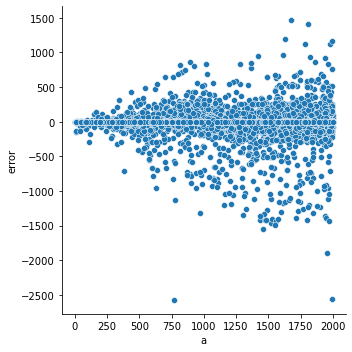

In [7]:
plot = sns.relplot(x = [x[0] for x in X_val], y = [e[0] for e in error])
plot.set(xlabel = 'a', ylabel = 'error')

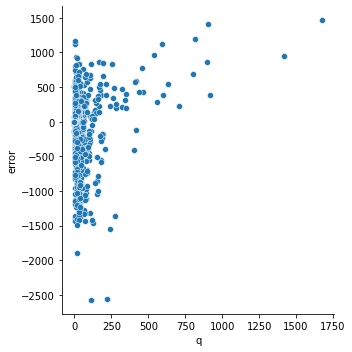

In [8]:
plot = sns.relplot(x = [y[0] for y in y_val], y = [e[0] for e in error])
plot.set(xlabel = 'q', ylabel = 'error')

Expected error is low  (and increases with $a$), but the variance is high. Note that using sine and cosine activation functions in the middle layers (as opposed to Relu) significantly decreased the varianace. How can we reduce it further?
